# 15.2 情感分析：使用循环神经网络
- **目录**
  - 15.2.1 使用循环神经网络表示单个文本
  - 15.2.2 加载用于情感分析的预训练词向量
  - 15.2.3 训练和评估情感分析模型（RNN版）


- 与词相似度和类比任务一样，也可以**将预先训练的词向量应用于情感分析**。
- 由于15.1节中的IMDb评论数据集不是很大，使用在大规模语料库上预训练的文本表示可以减少模型的过拟合。
- 作为图15.2.1中所示的具体示例，我们将**使用预训练的GloVe模型来表示每个词元，并将这些词元表示送入多层双向循环神经网络以获得文本序列表示，该文本序列表示将被转换为情感分析输出**。
- 对于相同的下游应用，我们稍后将考虑不同的架构选择。

<center><img src='../img/nlp-map-sa-rnn.svg'></center>
<center>图15.2.1 将GloVe送入基于循环神经网络的架构，用于情感分析</center>

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

-------
- **说明：d2l.load_data_imdb代码修改**
  - 将load_data_imdb函数中的data_dir变量修改成r'../data/aclimdb'。
  - 注意此修改使用中文windows平台，linux平台另行测试。
<img src='../img/15_2_1.png' width='800px'>

-----

In [2]:
## 训练数据与测试数据一样大
len(iter(test_iter)),len(iter(train_iter)),64*391

(391, 391, 25024)

In [3]:
list(iter(test_iter))[0][0].shape

torch.Size([64, 500])

In [4]:
len(vocab)

49346

## 15.2.1 使用循环神经网络表示单个文本
- 在文本分类任务（如情感分析）中，可变长度的文本序列将被转换为固定长度的类别。
- 在下面的`BiRNN`类中，虽然**文本序列的每个词元经由嵌入层（`self.embedding`）获得其单独的预训练GloVe表示** ，但是整个序列由双向循环神经网络（`self.encoder`）编码。
- 更具体地说，**双向长短期记忆网络在初始和最终时间步的隐状态（在最后一层）被连结起来作为文本序列的表示。** 
- 然后，通过一个具有两个输出（“积极”和“消极”）的全连接层（`self.decoder`），将此单一文本表示转换为输出类别。


In [ ]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

- BiRNN详细注释

In [3]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        '''
        embed_size:100, num_hiddens:100, num_layers:2
        '''
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        '''
        4 * num_hiddens=400
        '''
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        '''
        影评数据是行向量，即每条评论放在一行里。
        此处转置，是为了将其设为列向量。LSTM要求第一维是时间维（序列长度）
        inputs.T=(500, 64),embedding_size=100
        输出embeddings的形状是(500,64,100), 最后一维是嵌入维
        '''
        embeddings = self.embedding(inputs.T)
        
        '''
        辅助作用，让参数都在连续内存块上，可以加快计算速度。
        只在GPU上可用。
        该方法仅重组内存，不改变参数值或梯度计算逻辑
        '''
        self.encoder.flatten_parameters()
        
        '''
        返回上一个隐藏层在不同时间步的隐状态，
        （时间步数，批量大小，2*隐藏单元数）
        这里2表示是双向LSTM。即此公式： (L, N, D * H_{out})
        D表示如果是双向RNN，则D=2
        outputs：(500, 64, 200)
        '''
        outputs, _ = self.encoder(embeddings)
        '''
        连结初始和最终时间步的隐状态，作为全连接层的输入，
        这是与RNN以及LSTM模型特征相关的。
        其形状为（批量大小，4*隐藏单元数）,本例为：(64, 400)，
        在列上进行横向拼接。
        '''
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

- **说明：为何将双向LSTM的输出的第一个和最后一个时间步的隐状态进行拼接作为全连接层的输入？**
  - encoding = torch.cat((outputs[0], outputs[-1]), dim=1)拼接第一个和最后一个时间步的隐状态。
  - **时序建模的完整性（参见图9.4.2）**
    - **双向RNN的特性**：双向结构包含前向（从左到右）和后向（从右到左）两个方向的LSTM。前向LSTM的最后一个时间步隐藏状态（`h_T_forward`）编码了**整个序列的上下文信息**，而后向LSTM的第一个时间步隐藏状态（`h_1_backward`）同样编码了**全局上下文**（因为后向LSTM是逆序处理输入）。
    - **拼接首尾状态**：将前向的`h_1_forward`（序列开头）与`h_T_forward`（序列结尾）以及后向的`h_1_backward`（实际是序列结尾）与`h_T_backward`（实际是序列开头）拼接，相当于同时捕获了：
      - **序列起始特征**（前向`h_1` + 后向`h_T`）
      - **序列结束特征**（前向`h_T` + 后向`h_1`）
    - **全面表征**：这种拼接方式比仅使用最后一个时间步的输出更能覆盖序列的全局信息，尤其对长文本的情感分析更鲁棒。
  - **情感分析任务的特性**
    - **情感表达模式**：在文本情感分析中，用户表达情感常呈现以下模式：
      - **开头**可能包含主题引入（如“这部电影”）。
      - **结尾**往往总结情感（如“太精彩了！”或“非常失望”）。
    - **关键位置特征**：首尾位置的隐藏状态通常携带更强烈的分类信号，而中间部分可能是细节描述（对分类贡献较小）。实验表明，仅用首尾状态的简单策略在情感分析任务中已能取得较好效果，且计算高效。
  - **与LSTM记忆机制的协同**
    - **LSTM的长期记忆**：LSTM的细胞状态（`c_t`）理论上已携带序列的长期依赖信息，而隐藏状态（`h_t`）是其“过滤版本”。首尾的`h_t`差异可以反映序列整体的情感变化（如从中性描述到积极结论）。
    - **双向互补性**：前向和后向LSTM对同一位置的理解不同。例如：
      - 前向`h_T`更关注结尾词对前面内容的总结。
      - 后向`h_1`（对应原始序列的结尾）更关注结尾词对全文的回顾。
---

In [4]:
## 上文中横向列拼接的例子
s=torch.arange(12).reshape(3,4)
s1=torch.arange(12,24).reshape(3,4)
torch.cat((s,s1),dim=1)

tensor([[ 0,  1,  2,  3, 12, 13, 14, 15],
        [ 4,  5,  6,  7, 16, 17, 18, 19],
        [ 8,  9, 10, 11, 20, 21, 22, 23]])

- 让我们构造一个具有两个隐藏层的双向循环神经网络来表示单个文本以进行情感分析。


In [5]:
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

## 15.2.2 加载用于情感分析的预训练词向量

- 下面为词表中的单词加载预训练的100维（需要与`embed_size`一致）的GloVe嵌入。


In [7]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

-------
- **说明：d2l.TokenEmbedding代码修改**
  - 修改字符编码为utf-8，如不修改同样发生异常
<img src='../img/15_2_2.png' width='800px'>
-----

- 打印词表中所有词元向量的形状。


In [8]:
## 词表的词元进行嵌入编码
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

- 使用这些预训练的词向量来表示评论中的词元，并且在训练期间不要更新这些向量。


In [11]:
'''
将词向量深度拷贝到模型的权重数据（即下文的data）里,
而且该数据不进行梯度更新，只更新最后全连接层Linear的参数即可。
'''
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

## 15.2.3 训练和评估情感分析模型（RNN版）

- 现在我们可以训练双向循环神经网络进行情感分析。



KeyboardInterrupt



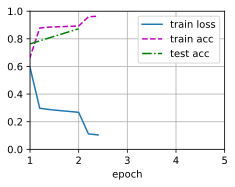

In [9]:
from time import time
start=time()
time()-start
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
print('训练时间：{0} 分钟'.format(int((time()-start)/60)))

- 我们定义以下函数来使用训练好的模型`net`预测文本序列的情感。


In [9]:
#@save
def predict_sentiment(net, vocab, sequence):
    """预测文本序列的情感"""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

- 最后，让我们使用训练好的模型对两个简单的句子进行情感预测。


In [10]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [11]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [12]:
predict_sentiment(net, vocab, 'this movie is bad')

'negative'

## 小结

* 预训练的词向量可以表示文本序列中的各个词元。
* 双向循环神经网络可以表示文本序列。例如通过连结初始和最终时间步的隐状态，可以使用全连接的层将该单个文本表示转换为类别。
